# Starting out with Bokeh

## One Variable Plotting

In this notebook, we will get our first experience with [Bokeh](https://bokeh.pydata.org/en/latest/), a powerful plotting library accessible through Python. Throughout this series of notebooks, we will use the [nycflights13](https://cran.r-project.org/web/packages/nycflights13/nycflights13.pdf) dataset. 

In [4]:
import pandas as pd
import numpy as np
import os, sys

In [5]:
from bokeh.plotting import figure

from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Category10_5, Category20_16

# Data Inspection

In [6]:
# Set Paths
repo = os.path.dirname(os.getcwd())
path_data = os.path.join(repo, "data")
path_data_raw = os.path.join(path_data, "raw")

In [7]:
file = os.path.join(path_data_raw, "flights.csv")
flights = pd.read_csv(file, index_col=0)
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
1,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
2,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
3,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
4,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
5,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00


In [8]:
sys.getsizeof(flights) / 1e9

0.147428443

We are going to focus on a single variable, in this case the arrival delay in minutes. Before we get into plotting, we will want to take a look at the summary statistics for the arrival delay.

In [9]:
flights['arr_delay'].describe()

count    327346.000000
mean          6.895377
std          44.633292
min         -86.000000
25%         -17.000000
50%          -5.000000
75%          14.000000
max        1272.000000
Name: arr_delay, dtype: float64

# Histogram 

The first graph we will make is a simple histogram of the arrival delay. We will consider all airlines on the same plot.

## Data for plotting

In [10]:
# Bins will be five minutes in width, limit delays to [-2, +2] hours
arr_hist, edges = np.histogram(flights['arr_delay'], bins = int(240/5), range = [-120, 120])

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [11]:
# Set up the figure
p = figure(plot_width = 500, plot_height = 500, title = 'Histogram of Arrival Delays',
          x_axis_label = 'Minutes', y_axis_label = 'Count')

# Add a quad glyph
p.quad(bottom=0, top=arr_hist, left=edges[:-1], right=edges[1:], fill_color='red', line_color='black')

# To show in notebook
output_notebook()

# Show the plot
show(p)

Loading BokehJS ...

# Add Basic Styling

In [12]:
def style(p):
    p.title.align = 'center'
    p.title.text_font_size = '18pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    
    return p

In [13]:
styled_p = style(p)

show(styled_p)

# Column Data Source

In [14]:
arr_df = pd.DataFrame({'count': arr_hist, 'left': edges[:-1], 'right': edges[1:]})
arr_df['f_count'] = ['%d flights' % count for count in arr_df['count']]
arr_df['f_interval'] = ['%d to %d minutes' % (left, right) for left, right in zip(arr_df['left'], arr_df['right'])]

arr_df.head()

,count,left,right,f_count,f_interval
0,0,-120.0,-115.0,0 flights,-120 to -115 minutes
1,0,-115.0,-110.0,0 flights,-115 to -110 minutes
2,0,-110.0,-105.0,0 flights,-110 to -105 minutes
3,0,-105.0,-100.0,0 flights,-105 to -100 minutes
4,0,-100.0,-95.0,0 flights,-100 to -95 minutes


In [15]:
arr_src = ColumnDataSource(arr_df)

In [16]:
arr_src.data.keys()

dict_keys(['index', 'count', 'left', 'right', 'f_count', 'f_interval'])

# Add in Tooltips on Hover

In [17]:
# Set up the figure same as before
p = figure(plot_width = 500, plot_height = 500, title = 'Histogram of Arrival Delays',
          x_axis_label = 'Minutes', y_axis_label = 'Count')

# Add a quad glyph with source this time
p.quad(bottom=0, top='count', left='left', right='right', source=arr_src,
       fill_color='red', line_color='black')

# Add style to the plot
styled_p = style(p)

# Add a hover tool referring to the formatted columns
hover = HoverTool(tooltips = [('Delay', '@f_interval'),
                              ('Count', '@f_count')])

# Add the hover tool to the graph
styled_p.add_tools(hover)

# Show the plot
show(styled_p)

# Percentage of Delay Histogram for each Carrier

In [18]:
# Group by the carrier to find the most common
carrier_nums = flights.groupby('carrier')['year'].count().sort_values(ascending=False)

In [19]:
carrier_nums

carrier
UA    58665
B6    54635
EV    54173
DL    48110
AA    32729
MQ    26397
US    20536
9E    18460
WN    12275
VX     5162
FL     3260
AS      714
F9      685
YV      601
HA      342
OO       32
Name: year, dtype: int64

In [20]:
# Subset to the 8 most common carriers
flights = flights[flights['carrier'].isin(carrier_nums.index[:5])]

# Subset to only [-2, +2] hour delays
flights = flights[(flights['arr_delay'] >= -120) & (flights['arr_delay'] <= 120)]

## Find actual carrier names

In [25]:
file = os.path.join(path_data_raw, "airlines.csv")
carrier_names = pd.read_csv(file)
carrier_names.head()

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.


In [26]:
flights = flights.merge(carrier_names, how = 'left', on = 'carrier')
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.


In [27]:
by_carrier = pd.DataFrame(columns=['proportion', 'left', 'right', 
                                   'f_proportion', 'f_interval',
                                   'name', 'color'])

# Iterate through all the carriers
for i, carrier_name in enumerate(flights['name'].unique()):
    
    # Subset to the carrier
    subset = flights[flights['name'] == carrier_name]
    
    # Create a histogram with 5 minute bins
    arr_hist, edges = np.histogram(subset['arr_delay'], bins = int(240/5), range = [-120, 120])
    
    # Divide the counts by the total to get a proportion
    arr_df = pd.DataFrame({'proportion': arr_hist / np.sum(arr_hist), 'left': edges[:-1], 'right': edges[1:] })
    
    # Format the proportion 
    arr_df['f_proportion'] = ['%0.5f' % proportion for proportion in arr_df['proportion']]
    
    # Format the interval
    arr_df['f_interval'] = ['%d to %d minutes' % (left, right) for left, right in zip(arr_df['left'], arr_df['right'])]
    
    # Assign the carrier for labels
    arr_df['name'] = carrier_name
    
    # Color each carrier differently
    arr_df['color'] = Category10_5[i]

    # Add to the overall dataframe
    by_carrier = by_carrier.append(arr_df)
    
# Overall dataframe
by_carrier = by_carrier.sort_values(['name', 'left'])

In [28]:
by_carrier.head()

,proportion,left,right,f_proportion,f_interval,name,color
0,0.0,-120.0,-115.0,0.00000,-120 to -115 minutes,American Airlines Inc.,#ff7f0e
1,0.0,-115.0,-110.0,0.00000,-115 to -110 minutes,American Airlines Inc.,#ff7f0e
2,0.0,-110.0,-105.0,0.00000,-110 to -105 minutes,American Airlines Inc.,#ff7f0e
3,0.0,-105.0,-100.0,0.00000,-105 to -100 minutes,American Airlines Inc.,#ff7f0e
4,0.0,-100.0,-95.0,0.00000,-100 to -95 minutes,American Airlines Inc.,#ff7f0e


In [29]:
by_carrier_src = ColumnDataSource(by_carrier)

In [30]:
# Create the figure
p = figure(plot_height = 600, plot_width = 800, title = 'Histogram of Airline Delays by Carrier',
          x_axis_label = 'Arrival Delay (min)', y_axis_label = 'Proportion')

# Add the quad glpyh with the source by carrier
p.quad(bottom = 0, left = 'left', right = 'right', top = 'proportion',
       fill_color = 'color',  legend = 'name', source = by_carrier_src,
      fill_alpha = 0.6, hover_fill_alpha = 1.0, hover_fill_color = 'color')

# Create the hover tool
hover = HoverTool(tooltips = [('Carrier', '@name'),
                              ('Proportion', '@f_proportion'),
                              ('Delay', '@f_interval')],
                 mode = 'vline')

# Add styling and hover tool
styled_p = style(p)
styled_p.add_tools(hover)
output_notebook()
show(styled_p)

Loading BokehJS ...

# Simpler Approach using Seaborn

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

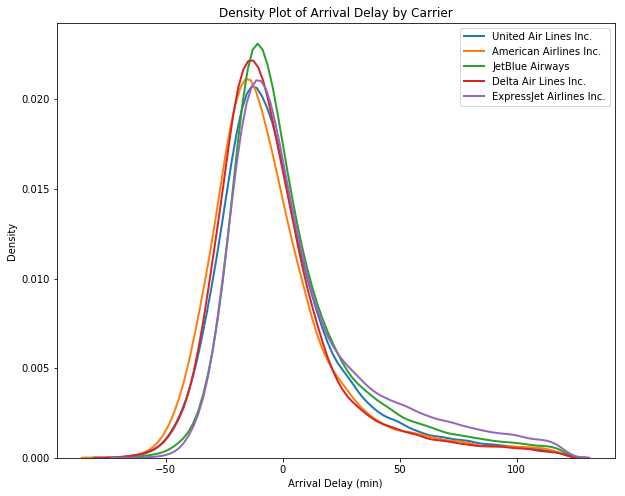

In [32]:
# Create a figure
plt.figure(figsize=(10, 8))

# Iterate through each carrier and make a density plot (kde)
for i, carrier in enumerate(flights['name'].unique()):
    subset = flights[flights['name'] == carrier]
    sns.kdeplot(subset['arr_delay'], color = Category10_5[i], label = '%s' % carrier, lw = 2 );

plt.xlabel('Arrival Delay (min)')
plt.ylabel('Density')
plt.title('Density Plot of Arrival Delay by Carrier')
plt.legend();

In [35]:
file = os.path.join(path_data_raw, "by_carrier.csv")
by_carrier = pd.read_csv(file, index_col=0)
available_carriers = list(by_carrier['name'].unique())

In [36]:
by_carrier.head()


,color,f_interval,f_proportion,left,name,proportion,right
0,#c5b0d5,-120 to -115 minutes,0.0,-120.0,AirTran Airways Corporation,0.0,-115.0
1,#c5b0d5,-115 to -110 minutes,0.0,-115.0,AirTran Airways Corporation,0.0,-110.0
2,#c5b0d5,-110 to -105 minutes,0.0,-110.0,AirTran Airways Corporation,0.0,-105.0
3,#c5b0d5,-105 to -100 minutes,0.0,-105.0,AirTran Airways Corporation,0.0,-100.0
4,#c5b0d5,-100 to -95 minutes,0.0,-100.0,AirTran Airways Corporation,0.0,-95.0


# References

src: https://github.com/WillKoehrsen/Bokeh-Python-Visualization/blob/master/intro/exploration/first_histogram.ipynb

https://github.com/WillKoehrsen/Bokeh-Python-Visualization/blob/master/intro/exploration/first_histogram_article.ipynb